使用TensorFlow的中阶API实现线性回归模型和和DNN二分类模型

TensorFlow的中阶API主要包括各种模型层，损失函数，优化器，数据管道，特征列等等。

In [1]:
import tensorflow as tf

# 打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)
    
    hour = tf.cast(today_ts//3600+8, tf.int32) % tf.constant(24)
    minit = tf.cast(today_ts%3600//60, tf.int32)
    second = tf.cast(tf.floor(today_ts%60), tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format('{}', m)) == 1:
            return tf.strings.format('0{}', m)
        else:
            return tf.strings.format('{}', m)
        
    timestring = tf.strings.join([timeformat(hour), timeformat(minit), timeformat(second)], separator=':')
    tf.print('========'*8 + timestring)

# 1. 线性回归模型

## 1.1 数据准备

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

n = 400

x = tf.random.uniform([n, 2], minval=-10, maxval=10)
w0 = tf.constant([[2.0], [-3.0]])
b0 = tf.constant([[3.0]])
y = x@w0 + b0 + tf.random.normal([n, 1], mean=0.0, stddev=2.0)

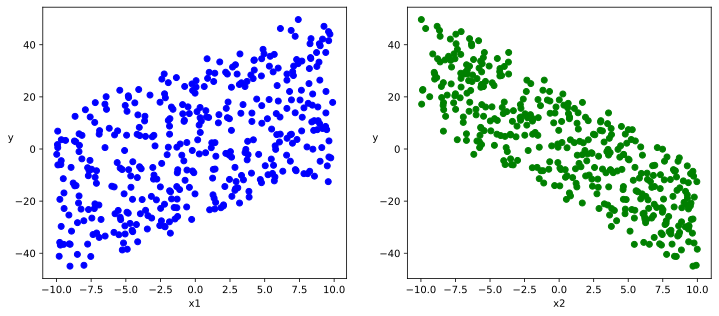

In [3]:
# 数据可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(x[:, 0], y[:, 0], c='b')
plt.xlabel('x1')
plt.ylabel('y', rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(x[:, 1], y[:, 0], c='g')
plt.xlabel('x2')
plt.ylabel('y', rotation=0)
plt.show()

In [20]:
# 构建输入数据管道
ds = tf.data.Dataset.from_tensor_slices((x, y)) \
    .shuffle(buffer_size=100).batch(10) \
    .prefetch(tf.data.experimental.AUTOTUNE)

## 1.2 定义模型

In [21]:
from tensorflow.keras import layers, losses, metrics, optimizers

model = layers.Dense(units=1)
# 用build方法创建variables
model.build(input_shape=(2,))
model.loss_func = losses.mean_squared_error
model.optimizer = optimizers.SGD(learning_rate=0.001)

## 1.3 训练模型

In [28]:
# 使用autograph机制转换为静态图加速

@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(tf.reshape(labels, [-1]), tf.reshape(predictions, [-1]))
    grads = tape.gradient(loss, model.variables)
    model.optimizer.apply_gradients(zip(grads, model.variables))
    return loss
    
def train_model(model, epochs):
    for epoch in tf.range(1, epochs+1):
        loss = tf.constant(0.0)
        for features, labels in ds:
            loss = train_step(model, features, labels)
        if epoch % 50 == 0:
            printbar()
            tf.print('epoch =', epoch, 'loss =', loss)
            tf.print('w =', model.variables[0])
            tf.print('b =', model.variables[1])

train_model(model, 200)

================================================================14:41:22
epoch = 50 loss = 2.87001038
w = [[1.96254992]
 [-2.98568082]]
b = [3.04821587]
================================================================14:41:24
epoch = 100 loss = 2.90157652
w = [[1.94961905]
 [-2.98920965]]
b = [3.04871345]
================================================================14:41:25
epoch = 150 loss = 1.66673052
w = [[1.97278035]
 [-2.99572182]]
b = [3.04616737]
================================================================14:41:27
epoch = 200 loss = 2.3294518
w = [[1.97220731]
 [-3.00234795]]
b = [3.04793715]


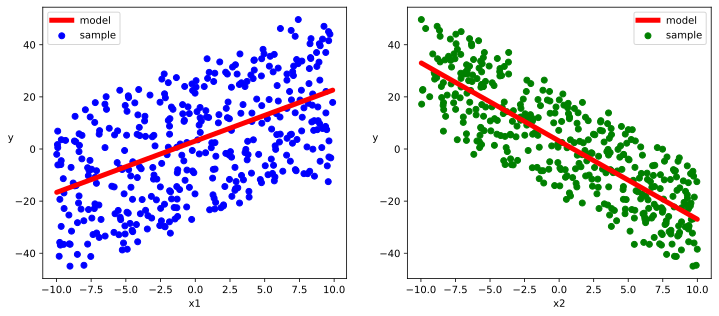

In [32]:
# 结果可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w, b = model.variables

plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(x[:, 0], y[:, 0], c='b', label='sample')
ax1.plot(x[:, 0], w[0]*x[:, 0] + b[0], '-r', linewidth=5.0, label='model')
ax1.legend()
plt.xlabel('x1')
plt.ylabel('y', rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(x[:, 1], y[:, 0], c='g', label='sample')
ax2.plot(x[:, 1], w[1]*x[:, 1] + b[0], '-r', linewidth=5.0, label='model')
ax2.legend()
plt.xlabel('x2')
plt.ylabel('y', rotation=0)
plt.show()

# 2. DNN二分类模型

## 2.1 数据准备

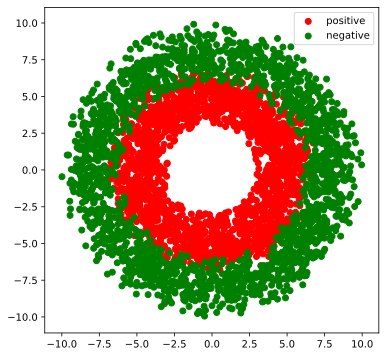

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 样本数量
n_positive, n_negative = 2000, 2000

# 生成正样本，小圆环
r_p = 5.0 + tf.random.truncated_normal([n_positive, 1], 0.0, 1.0)
theta_p = tf.random.uniform([n_positive, 1], 0.0, 2*np.pi)
Xp = tf.concat([r_p*tf.cos(theta_p), r_p*tf.sin(theta_p)], axis=1)
Yp = tf.ones_like(r_p)

# 生成负样本，大圆环
r_n = 8.0 + tf.random.truncated_normal([n_negative, 1], 0.0, 1.0)
theta_n = tf.random.uniform([n_negative, 1], 0, 2*np.pi)
Xn = tf.concat([r_n*tf.cos(theta_n), r_n*tf.sin(theta_n)], axis=1)
Yn = tf.zeros_like(r_n)

# 样本汇总
X = tf.concat([Xp, Xn], axis=0)
Y = tf.concat([Yp, Yn], axis=0)

# 绘图
plt.figure(figsize=(6, 6))
plt.scatter(Xp[:, 0].numpy(), Xp[:, 1].numpy(), c='r')
plt.scatter(Xn[:, 0].numpy(), Xn[:, 1].numpy(), c='g')
plt.legend(['positive', 'negative'])

In [34]:
# 构建输入数据管道
ds = tf.data.Dataset.from_tensor_slices((X, Y)) \
        .shuffle(buffer_size=4000).batch(100) \
        .prefetch(tf.data.experimental.AUTOTUNE)

## 2.2 定义模型

In [44]:
from tensorflow.keras import layers, losses, metrics, optimizers

class DNNModel(tf.Module):
    def __init__(self, name=None):
        super(DNNModel, self).__init__(name=name)
        self.dense1 = layers.Dense(4, activation='relu')
        self.dense2 = layers.Dense(8, activation='relu')
        self.dense3 = layers.Dense(1, activation='sigmoid')
        
    # 正向传播
    @tf.function(input_signature=[tf.TensorSpec(shape=(None, 2), dtype=tf.float32)])
    def __call__(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        y = self.dense3(x)
        return y
    
model = DNNModel()
model.loss_func = losses.binary_crossentropy
model.metric_func = metrics.binary_accuracy
model.optimizer = optimizers.Adam(learning_rate=0.001)

## 2.3 训练模型

In [47]:
# 使用autograph机制转为静态图加速
@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(tf.reshape(labels, [-1]), tf.reshape(predictions, [-1]))
    grads = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    metric = model.metric_func(tf.reshape(labels, [-1]), tf.reshape(predictions, [-1]))
    return loss, metric

def train_model(model, epochs):
    for epoch in tf.range(1, epochs+1):
        loss = tf.constant(0.0)
        metric = tf.constant(0.0)
        for features, labels in ds:
            loss, metric = train_step(model, features, labels)
        if epoch % 10 == 0:
            printbar()
            tf.print('epoch =', epoch, 'loss =', loss, 'metric =', metric)

train_model(model, 60)

================================================================17:07:58
epoch = 10 loss = 0.230103076 metric = 0.92
================================================================17:07:59
epoch = 20 loss = 0.168436438 metric = 0.94
================================================================17:07:59
epoch = 30 loss = 0.173452392 metric = 0.94
================================================================17:08:00
epoch = 40 loss = 0.135578021 metric = 0.96
================================================================17:08:00
epoch = 50 loss = 0.115902893 metric = 0.96
================================================================17:08:00
epoch = 60 loss = 0.119483531 metric = 0.96


F:\software_install\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


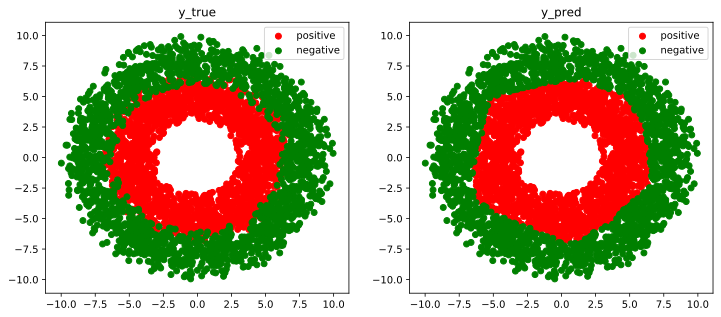

In [48]:
# 结果可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:, 0], Xp[:, 1], c='r')
ax1.scatter(Xn[:, 0], Xn[:, 1], c='g')
ax1.legend(['positive', 'negative'])
ax1.set_title('y_true')

Xp_pred = tf.boolean_mask(X, tf.squeeze(model(X)>=0.5), axis=0)
Xn_pred = tf.boolean_mask(X, tf.squeeze(model(X)<0.5), axis=0)

ax2.scatter(Xp_pred[:, 0], Xp_pred[:, 1], c='r')
ax2.scatter(Xn_pred[:, 0], Xn_pred[:, 1], c='g')
ax2.legend(['positive', 'negative'])
ax2.set_title('y_pred')
fig.show()